In [1]:
# =============================================================================
# 1. IMPORTS & SETUP
# =============================================================================
import numpy as np
import pandas as pd
from IPython.display import display
import re

# Sklearn & related imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Other libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Load data
# Make sure the path to your CSV file is correct
df_weather2 = pd.read_csv('/Users/shayan/Desktop/IDS2/Stattkueche/df_weather3.csv', parse_dates=['DateOfCancel', 'DateOfService'])



In [2]:
# =============================================================================
# 2. CUSTOM TRANSFORMER DEFINITIONS
# =============================================================================

class InCVTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, smoothing=1.0):
        self.cols = cols
        self.smoothing = smoothing

    def fit(self, X, y):
        self.global_mean_ = y.mean()
        self.mapping_ = {}
        for c in self.cols:
            df = pd.DataFrame({c: X[c], 'target': y})
            agg = df.groupby(c)['target'].agg(['mean', 'count'])
            agg['enc'] = ((agg['count'] * agg['mean'] + self.smoothing * self.global_mean_) / (agg['count'] + self.smoothing))
            self.mapping_[c] = agg['enc']
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.cols:
            X[c + '_te'] = X[c].map(self.mapping_.get(c)).fillna(self.global_mean_)
        return X

class HistCancelRateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_keys=('Site','MenuBase'), value_col='net_qty', out_col='hist_cancel_rate'):
        self.group_keys = group_keys
        self.value_col  = value_col
        self.out_col    = out_col
    def fit(self, X, y=None):
        keys = list(self.group_keys)
        self.hist_    = X.groupby(keys)[self.value_col].mean()
        self.default_ = self.hist_.median()
        return self
    def transform(self, X):
        keys = list(self.group_keys)
        tuples = [tuple(r) for r in X[keys].values]
        X = X.copy()
        X[self.out_col] = [self.hist_.get(t, self.default_) for t in tuples]
        return X

class ClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, profile_feats, group_keys=('Site','MenuBase'), n_clusters=5, out_col='cluster_id'):
        self.profile_feats = profile_feats
        self.group_keys    = group_keys
        self.n_clusters    = n_clusters
        self.out_col       = out_col
    def fit(self, X, y=None):
        keys = list(self.group_keys)
        prof = (X.groupby(keys)[self.profile_feats].mean().reset_index())
        prof[self.profile_feats] = prof[self.profile_feats].fillna(prof[self.profile_feats].median())
        self.scaler_ = StandardScaler().fit(prof[self.profile_feats])
        scaled = self.scaler_.transform(prof[self.profile_feats])
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10).fit(scaled)
        tuples = [tuple(r) for r in prof[keys].values]
        self.cluster_map_ = dict(zip(tuples, self.kmeans_.labels_))
        self.default_ = int(np.median(self.kmeans_.labels_))
        return self
    def transform(self, X):
        X = X.copy()
        keys = list(self.group_keys)
        tuples = [tuple(r) for r in X[keys].values]
        X[self.out_col] = [self.cluster_map_.get(t, self.default_) for t in tuples]
        return X

class MissingFlagImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median'):
        self.strategy = strategy
    def fit(self, X, y=None):
        self.num_cols = X.select_dtypes(include=[np.number]).columns
        clean = X[self.num_cols].replace([np.inf,-np.inf], np.nan)
        self.imputer_ = SimpleImputer(strategy=self.strategy).fit(clean)
        return self
    def transform(self, X):
        X = X.copy()
        X[self.num_cols] = X[self.num_cols].replace([np.inf,-np.inf], np.nan)
        for c in self.num_cols:
            X[c + '_missing'] = X[c].isna().astype(int)
        X[self.num_cols] = self.imputer_.transform(X[self.num_cols])
        return X

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(columns=self.cols_to_drop, errors='ignore')

# ✅ FIX: This new transformer cleans column names to prevent errors in some models
class FeatureNameSanitizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = X.copy()
        # Remove special characters that cause errors in LightGBM/XGBoost
        df.columns = [re.sub(r'[^A-Za-z0-9_]+', '', str(col)) for col in df.columns]
        return df



In [3]:
# =============================================================================
# 3. VIF CHECK (FIXED)
# =============================================================================
num_cols = df_weather2.select_dtypes(include=[np.number]).columns.to_list()
drop_col = ['DateOfOrder', 'DateOfService','days_to_cancel','CanceledQty','OrderId', 'TransactionId','cancel_timing','BookingNr','DateOfCancel','net_qty']
vif_col_1 = [c for c in num_cols if c not in drop_col]

# ✅ FIX: Corrected typo from df_encoded to df_weather2
vif_dat_1 = df_weather2[vif_col_1].copy()
vif_dat_1.replace([np.inf,-np.inf],np.nan,inplace=True)
vif_dat_1 = vif_dat_1.dropna()

vif_scores_1 = [variance_inflation_factor(vif_dat_1.values, i) for i in range(vif_dat_1.shape[1])]
vif_table_1 = (pd.DataFrame({'feature':vif_col_1,'VIF':vif_scores_1}).sort_values('VIF',ascending=False).reset_index(drop=True))

print('VIF values')
display(vif_table_1)

hg_vif_1 = vif_table_1.loc[vif_table_1['VIF']>10,'feature'].to_list()
print('\nHigh VIF columns to be aware of (or drop):')
print(hg_vif_1)



/Users/shayan/Desktop/IDS2/Stattkueche/venv_arm/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF values


,feature,VIF
0,afternoon,inf
1,morning,inf
2,evening,inf
3,day_of_year,3.102898e+04
4,month,3.086469e+04
5,day_of_month,1.300759e+02
6,quarter,2.209046e+01
7,MenuSubsidy,6.593575e+00
8,MenuPrice,6.495096e+00
9,order_hour,5.359547e+00



High VIF columns to be aware of (or drop):
['afternoon', 'morning', 'evening', 'day_of_year', 'month', 'day_of_month', 'quarter']


In [4]:
# =============================================================================
# 4. STAGE A: CANCELLATION PREDICTION (BINARY CLASSIFICATION - FASTER ⚡)
# =============================================================================
df_A = df_weather2.copy()
y_A = (df_A['CanceledQty'] > 0).astype(int)
X_A = df_A.drop(columns=[
    'CanceledQty', 'cancel_timing', 'DateOfOrder', 'DateOfService', 'DateOfCancel',
    'OrderId', 'TransactionId', 'BookingNr', 'hist_cancel_rate', 'GroupName', 'SchoolID'
])

# --- Optimization: Use a smaller sample for a quick run ---
print("Creating a 25% data sample for Stage A to run faster...")
sample_indices = df_A.sample(frac=0.25, random_state=42).index
X_A_sample = X_A.loc[sample_indices].copy()
y_A_sample = y_A.loc[sample_indices].copy()

drop_cols_A = ['Site','MenuBase','MenuName','GroupName','MenuNorm','MenuCode','net_qty','days_to_cancel']

pipeline_A = ImbPipeline([
    ('te',      InCVTargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)),
    ('hist',    HistCancelRateTransformer()),
    ('cluster', ClusterTransformer(
                   profile_feats=['hist_cancel_rate','rain_flag','temp_dev','sin_doy', 'cos_doy', 'month',
       'day_of_month', 'is_month_end', 'is_month_start','tavg_C', 'prcp_mm'],
                   n_clusters=5)),
    ('drop',    ColumnDropper(drop_cols_A)),
    ('impute',  MissingFlagImputer()),
    ('clf',     RandomForestClassifier(
                   n_estimators=50, # Reduced for speed
                   criterion='entropy', max_depth=8,
                   min_samples_split=5, min_samples_leaf=1, max_features='sqrt',
                   class_weight='balanced_subsample', random_state=24, n_jobs=-1
               )),
])

# --- Optimization: Reduce cross-validation splits ---
tscv_fast = TimeSeriesSplit(n_splits=3)

print("Starting Stage A cross-validation on the smaller sample...")
scores_A = cross_val_score(pipeline_A, X_A_sample, y_A_sample, cv=tscv_fast, scoring='roc_auc', n_jobs=-1)
print(f"Stage A ROC-AUC (from fast run): {scores_A.mean():.4f}")



Creating a 25% data sample for Stage A to run faster...
Starting Stage A cross-validation on the smaller sample...
Stage A ROC-AUC (from fast run): 0.8529


In [5]:
# =============================================================================
# 5. STAGE B: TIMING PREDICTION (MULTICLASS CLASSIFICATION - FIXED & FASTER ⚡)
# =============================================================================
print("\n--- Starting Stage B ---")

# --- Setup: Use a smaller data sample for all models ---
df_B_sample = df_weather2[df_weather2.cancel_timing != 'no_cancel'].sample(frac=0.25, random_state=42)

le = LabelEncoder().fit(df_B_sample.cancel_timing)
y_B = le.transform(df_B_sample.cancel_timing)
X_B = df_B_sample.drop(columns=['CanceledQty', 'cancel_timing', 'DateOfOrder','DateOfService', 'DateOfCancel', 'OrderId','TransactionId','BookingNr','hist_cancel_rate', 'GroupName','SchoolID'])

# --- Define a single, robust base pipeline for all models ---
drop_cols_B = ['MenuName','GroupName','MenuNorm','MenuCode']
drop_post_B = ['Site','MenuBase','net_qty','days_to_cancel']

base_steps = [
    ('te', InCVTargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)),
    ('drop', ColumnDropper(drop_cols_B)),
    ('hist', HistCancelRateTransformer()),
    ('cluster', ClusterTransformer(profile_feats=['hist_cancel_rate','rain_flag','temp_dev','sin_doy', 'cos_doy', 'month', 'day_of_month', 'is_month_end', 'is_month_start','tavg_C', 'prcp_mm'], n_clusters=5)),
    ('drop_post', ColumnDropper(drop_post_B)),
    ('impute', MissingFlagImputer()),
    ('sanitize', FeatureNameSanitizer()), # ✅ FIX: Sanitize names before classifier
    ('smote', SMOTE(random_state=24))
]

# --- Optimization: Define fast search parameters ---
tscv_fast = TimeSeriesSplit(n_splits=3)
N_ITER_FAST = 5 # Number of parameter settings that are sampled

# --- Model 1: Random Forest ---
print("\nRunning Stage B with Random Forest...")
pipeline_rf = ImbPipeline(base_steps + [('clf', RandomForestClassifier(class_weight='balanced', random_state=24, n_jobs=-1))])
param_dist_rf = {'clf__n_estimators': [100, 200], 'clf__max_depth': [6, 10], 'clf__min_samples_split': [10, 20]}
search_rf = RandomizedSearchCV(pipeline_rf, param_distributions=param_dist_rf, n_iter=N_ITER_FAST, cv=tscv_fast, scoring='roc_auc_ovo_weighted', n_jobs=-1, random_state=24)
search_rf.fit(X_B, y_B)
print(f"Best RF ROC AUC (OVO weighted): {search_rf.best_score_:.4f}")
print(f"Best RF Params: {search_rf.best_params_}")

# --- Model 2: LightGBM ---
print("\nRunning Stage B with LightGBM...")
pipeline_lgbm = ImbPipeline(base_steps + [('clf', LGBMClassifier(objective='multiclass', num_class=len(le.classes_), random_state=24, n_jobs=-1))])
param_dist_lgbm = {'clf__n_estimators': [100, 300], 'clf__learning_rate': [0.05, 0.1], 'clf__num_leaves': [20, 31]}
search_lgbm = RandomizedSearchCV(pipeline_lgbm, param_distributions=param_dist_lgbm, n_iter=N_ITER_FAST, cv=tscv_fast, scoring='roc_auc_ovo_weighted', n_jobs=-1, random_state=24)
search_lgbm.fit(X_B, y_B)
print(f"Best LGBM ROC AUC (OVO weighted): {search_lgbm.best_score_:.4f}")
print(f"Best LGBM Params: {search_lgbm.best_params_}")

# --- Model 3: CatBoost ---
print("\nRunning Stage B with CatBoost...")
pipeline_cat = ImbPipeline(base_steps + [('clf', CatBoostClassifier(auto_class_weights='Balanced', loss_function='MultiClass', early_stopping_rounds=25, verbose=False, random_seed=24, thread_count=-1))])
param_dist_cat = {'clf__iterations': [200, 400], 'clf__learning_rate': [0.05, 0.1], 'clf__depth': [6, 8]}
search_cat = RandomizedSearchCV(pipeline_cat, param_distributions=param_dist_cat, n_iter=N_ITER_FAST, cv=tscv_fast, scoring='roc_auc_ovo', n_jobs=-1, random_state=24)
search_cat.fit(X_B, y_B)
print(f"Best CatBoost ROC AUC (OVO): {search_cat.best_score_:.4f}")
print(f"Best CatBoost Params: {search_cat.best_params_}")


--- Starting Stage B ---

Running Stage B with Random Forest...
Best RF ROC AUC (OVO weighted): 0.9127
Best RF Params: {'clf__n_estimators': 100, 'clf__min_samples_split': 10, 'clf__max_depth': 10}

Running Stage B with LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5510
[LightGBM] [Info] Number of data points in the train set: 29121, number of used features: 24
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Best LGBM ROC AUC (OVO weighted): 0.9300
Best LGBM Params: {'clf__num_leaves': 31, 'clf__n_estimators': 100, 'clf__learning_rate': 0.1}

Running Stage B with CatBoost...
Best CatBoost ROC AUC (OVO): 0.9103
Best CatBoost Params: {'clf__learning_rate': 0

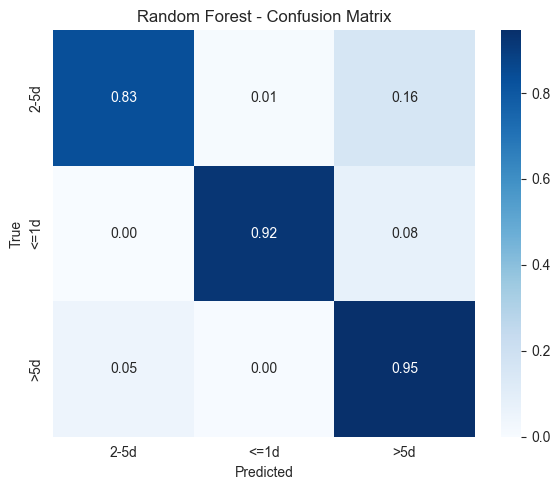


Classification Report - Random Forest:

              precision    recall  f1-score   support

        2-5d       0.66      0.83      0.74       230
        <=1d       0.71      0.92      0.80        26
         >5d       0.98      0.95      0.96      1942

    accuracy                           0.93      2198
   macro avg       0.78      0.90      0.83      2198
weighted avg       0.94      0.93      0.94      2198



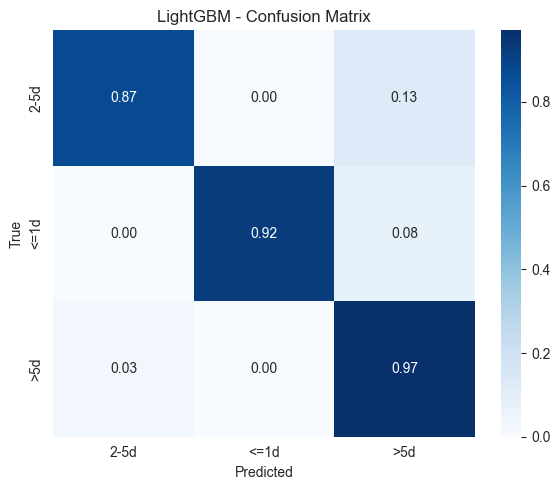


Classification Report - LightGBM:

              precision    recall  f1-score   support

        2-5d       0.79      0.87      0.83       230
        <=1d       0.83      0.92      0.87        26
         >5d       0.98      0.97      0.98      1942

    accuracy                           0.96      2198
   macro avg       0.87      0.92      0.89      2198
weighted avg       0.96      0.96      0.96      2198



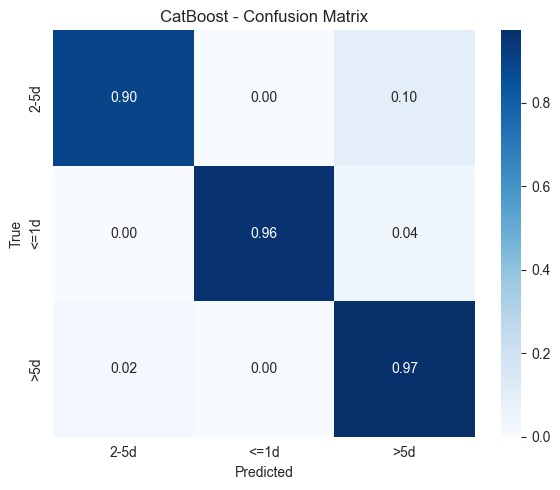


Classification Report - CatBoost:

              precision    recall  f1-score   support

        2-5d       0.82      0.90      0.86       230
        <=1d       0.78      0.96      0.86        26
         >5d       0.99      0.97      0.98      1942

    accuracy                           0.97      2198
   macro avg       0.86      0.94      0.90      2198
weighted avg       0.97      0.97      0.97      2198



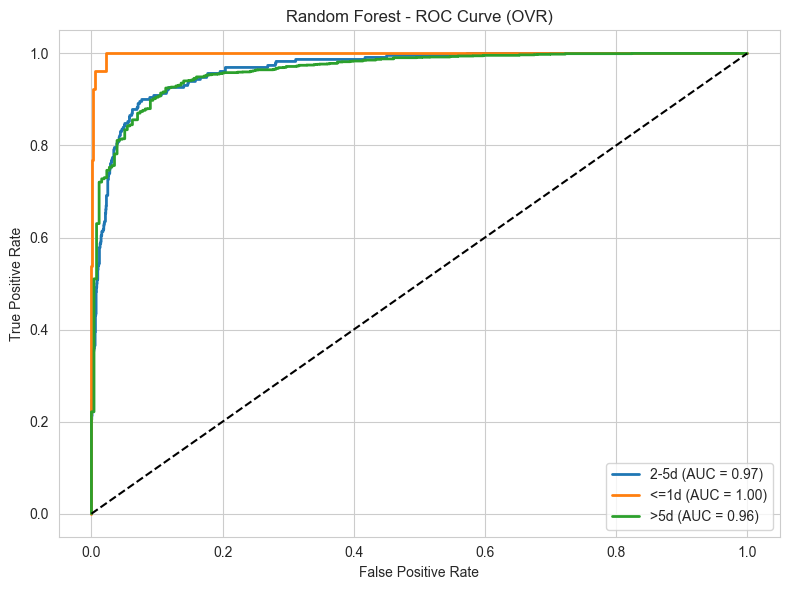

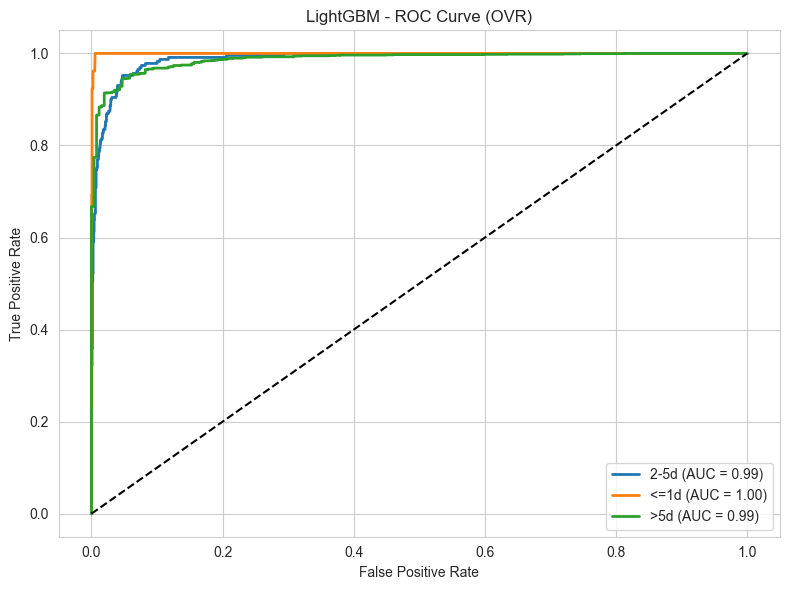

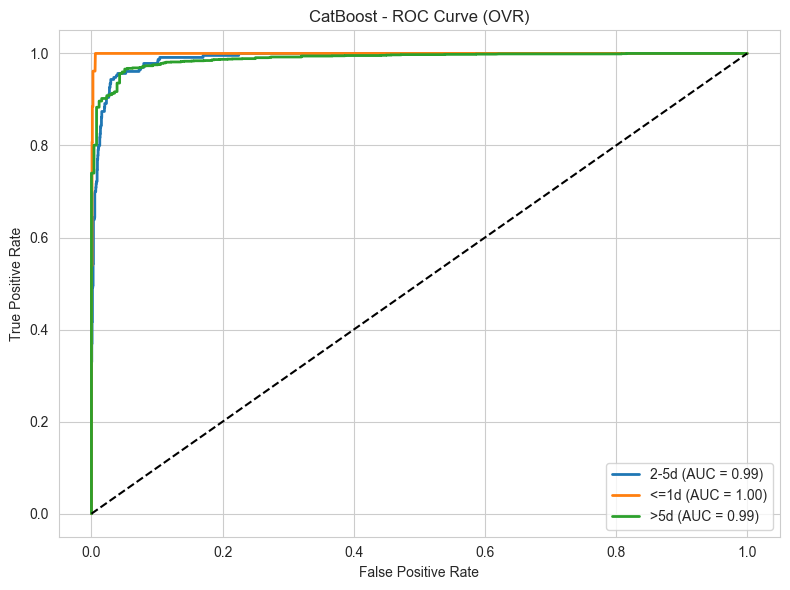

Feature importances not available for Random Forest.
Feature importances not available for LightGBM.
Feature importances not available for CatBoost.


/var/folders/_4/yzd4h3k95051tj7kpg425rk80000gn/T/ipykernel_46623/1453480881.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()), palette="pastel")


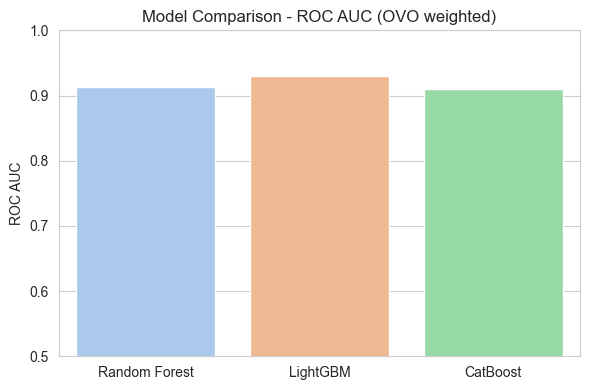

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# --- Prepare test predictions for all models ---
models = {
    "Random Forest": search_rf.best_estimator_,
    "LightGBM": search_lgbm.best_estimator_,
    "CatBoost": search_cat.best_estimator_
}

# Use a test split from X_B
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_B, y_B, test_size=0.2, random_state=42, stratify=y_B)
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))

# --- 1. Confusion Matrix and Classification Report ---
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Classification Report
    print(f"\nClassification Report - {name}:\n")
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    print(report)

# --- 2. ROC AUC Curve (One-vs-Rest) ---
for name, model in models.items():
    y_proba = model.predict_proba(X_test)
    fpr, tpr, roc_auc = {}, {}, {}
    plt.figure(figsize=(8, 6))

    for i in range(len(le.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{name} - ROC Curve (OVR)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# --- 3. Feature Importance ---
def plot_feature_importance(model, model_name):
    if hasattr(model.named_steps['clf'], 'feature_importances_'):
        features = model[:-1].transform(X_B).columns
        importances = model.named_steps['clf'].feature_importances_
        indices = np.argsort(importances)[::-1][:15]  # top 15 features

        plt.figure(figsize=(8, 6))
        sns.barplot(x=importances[indices], y=np.array(features)[indices], palette="viridis")
        plt.title(f"{model_name} - Top Feature Importances")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

for name, model in models.items():
    try:
        plot_feature_importance(model, name)
    except:
        print(f"Feature importances not available for {name}.")

# --- 4. Model Performance Comparison (ROC AUC) ---
model_scores = {
    "Random Forest": search_rf.best_score_,
    "LightGBM": search_lgbm.best_score_,
    "CatBoost": search_cat.best_score_,
}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()), palette="pastel")
plt.title("Model Comparison - ROC AUC (OVO weighted)")
plt.ylabel("ROC AUC")
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()


/var/folders/_4/yzd4h3k95051tj7kpg425rk80000gn/T/ipykernel_46623/2841655184.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=le.inverse_transform(y_B), palette='Set2')


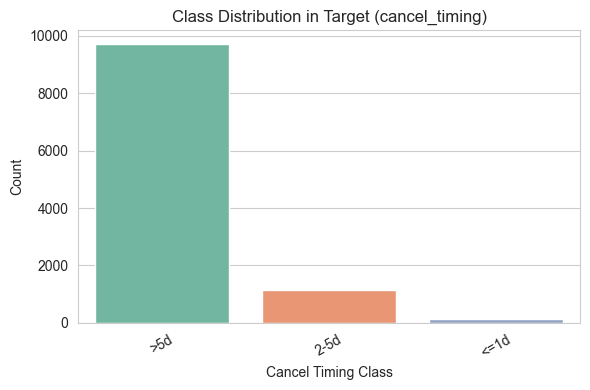

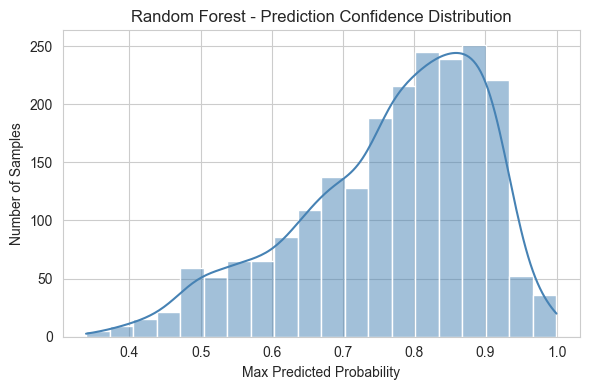

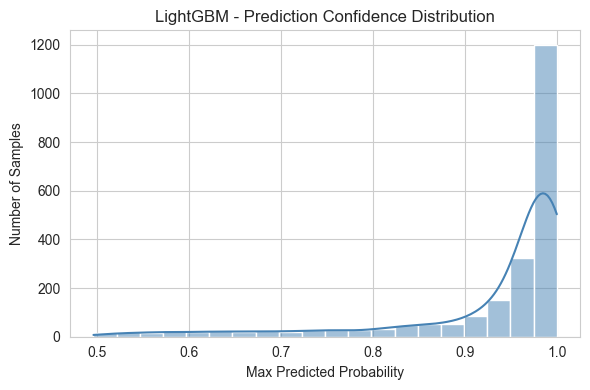

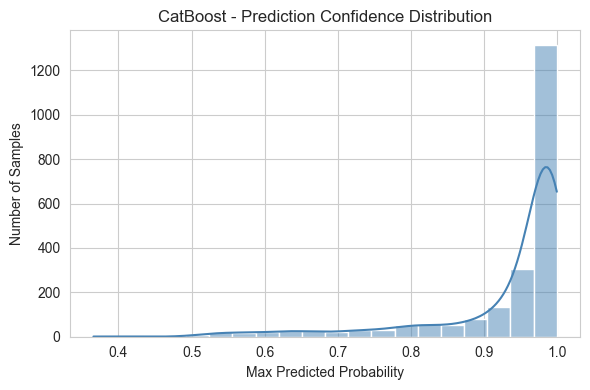

Could not plot calibration curve for Random Forest: This 'Pipeline' has no attribute 'transform'
Could not plot calibration curve for LightGBM: This 'Pipeline' has no attribute 'transform'
Could not plot calibration curve for CatBoost: This 'Pipeline' has no attribute 'transform'


/var/folders/_4/yzd4h3k95051tj7kpg425rk80000gn/T/ipykernel_46623/2841655184.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


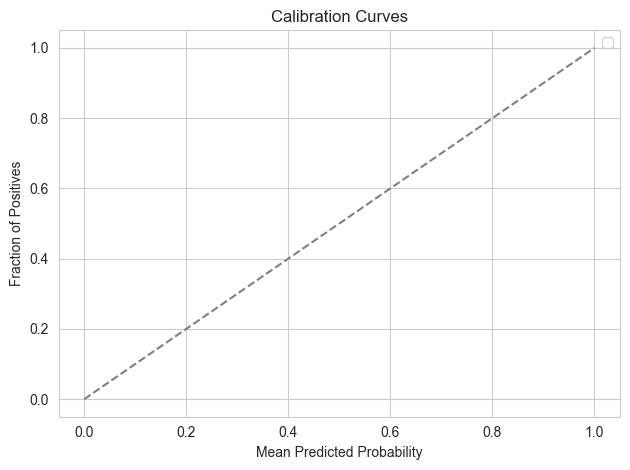


Per-Class Accuracy for Random Forest:

Class  Accuracy
  >5d  0.928939
 <=1d  0.923077
 2-5d  0.856522

Per-Class Accuracy for LightGBM:

Class  Accuracy
 <=1d  1.000000
 2-5d  0.982609
  >5d  0.712667

Per-Class Accuracy for CatBoost:

Class  Accuracy
 <=1d  0.961538
  >5d  0.944902
 2-5d  0.921739
Random Forest - Top-2 Accuracy: 0.9959 | Top-3 Accuracy: 1.0000


/Users/shayan/Desktop/IDS2/Stattkueche/venv_arm/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:2036: UndefinedMetricWarning: 'k' (3) greater than or equal to 'n_classes' (3) will result in a perfect score and is therefore meaningless.
  warnings.warn(


LightGBM - Top-2 Accuracy: 0.9945 | Top-3 Accuracy: 1.0000
CatBoost - Top-2 Accuracy: 0.9995 | Top-3 Accuracy: 1.0000


/Users/shayan/Desktop/IDS2/Stattkueche/venv_arm/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:2036: UndefinedMetricWarning: 'k' (3) greater than or equal to 'n_classes' (3) will result in a perfect score and is therefore meaningless.
  warnings.warn(
/Users/shayan/Desktop/IDS2/Stattkueche/venv_arm/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:2036: UndefinedMetricWarning: 'k' (3) greater than or equal to 'n_classes' (3) will result in a perfect score and is therefore meaningless.
  warnings.warn(


In [9]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import top_k_accuracy_score
import pandas as pd

# --- 5. Class Distribution in Target ---
plt.figure(figsize=(6, 4))
sns.countplot(x=le.inverse_transform(y_B), palette='Set2')
plt.title("Class Distribution in Target (cancel_timing)")
plt.ylabel("Count")
plt.xlabel("Cancel Timing Class")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# --- 6. Prediction Confidence Histogram ---
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)
    max_confidences = y_pred_proba.max(axis=1)

    plt.figure(figsize=(6, 4))
    sns.histplot(max_confidences, bins=20, kde=True, color='steelblue')
    plt.title(f"{name} - Prediction Confidence Distribution")
    plt.xlabel("Max Predicted Probability")
    plt.ylabel("Number of Samples")
    plt.tight_layout()
    plt.show()

# --- 7. Calibration Curve (Reliability Diagram) ---
from sklearn.calibration import CalibratedClassifierCV

for name, model in models.items():
    try:
        calibrated = CalibratedClassifierCV(model.named_steps['clf'], cv=3)
        X_trans = model[:-1].fit(X_train, y_train).transform(X_test)
        calibrated.fit(X_trans, y_test)

        prob_true, prob_pred = calibration_curve(y_test == y_test[0], calibrated.predict_proba(X_trans)[:, 0], n_bins=10)
        plt.plot(prob_pred, prob_true, marker='o', label=name)

    except Exception as e:
        print(f"Could not plot calibration curve for {name}: {e}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves")
plt.legend()
plt.tight_layout()
plt.show()

# --- 8. Per-Class Accuracy Table ---
def per_class_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    acc_per_class = cm.diagonal() / cm.sum(axis=1)
    return pd.DataFrame({
        "Class": le.classes_,
        "Accuracy": acc_per_class
    }).sort_values(by="Accuracy", ascending=False)

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc_table = per_class_accuracy(y_test, y_pred)
    print(f"\nPer-Class Accuracy for {name}:\n")
    print(acc_table.to_string(index=False))

# --- 9. Top-K Accuracy (Top-2 and Top-3) ---
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)
    top2 = top_k_accuracy_score(y_test, y_pred_proba, k=2)
    top3 = top_k_accuracy_score(y_test, y_pred_proba, k=3)
    print(f"{name} - Top-2 Accuracy: {top2:.4f} | Top-3 Accuracy: {top3:.4f}")



✅ GENERATING PERFORMANCE VISUALIZATIONS & ANALYSIS...


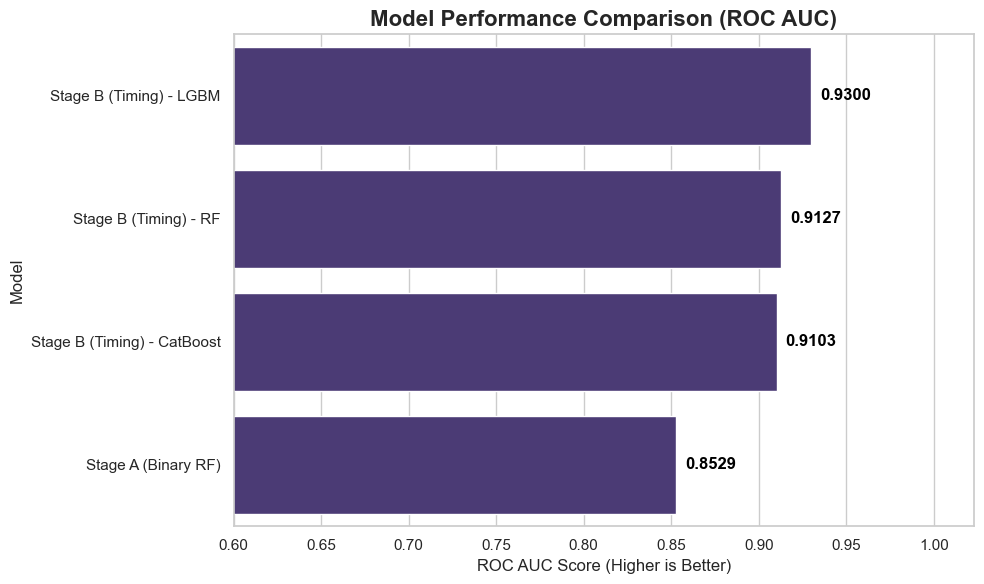


Performing detailed analysis on the best Stage B model: **LightGBM**

Manually generating cross-validated predictions to respect time-series structure...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 7281, number of used features: 24
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5284
[LightGBM] [Info] Number of data points in the train set: 14484, number

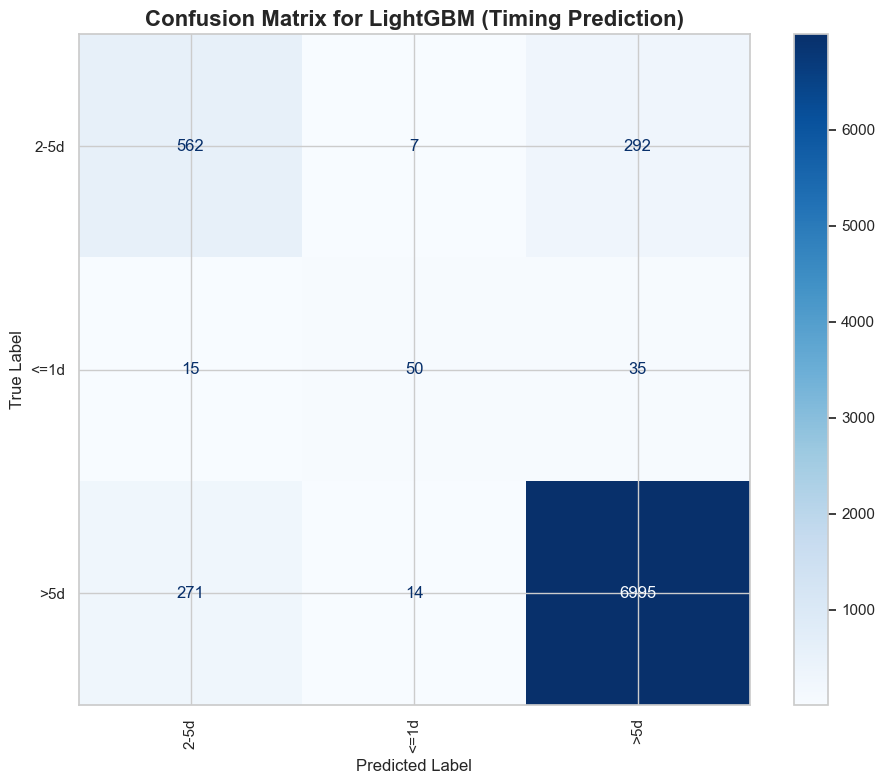

/var/folders/_4/yzd4h3k95051tj7kpg425rk80000gn/T/ipykernel_46623/1304764928.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20), orient='h', palette='rocket')


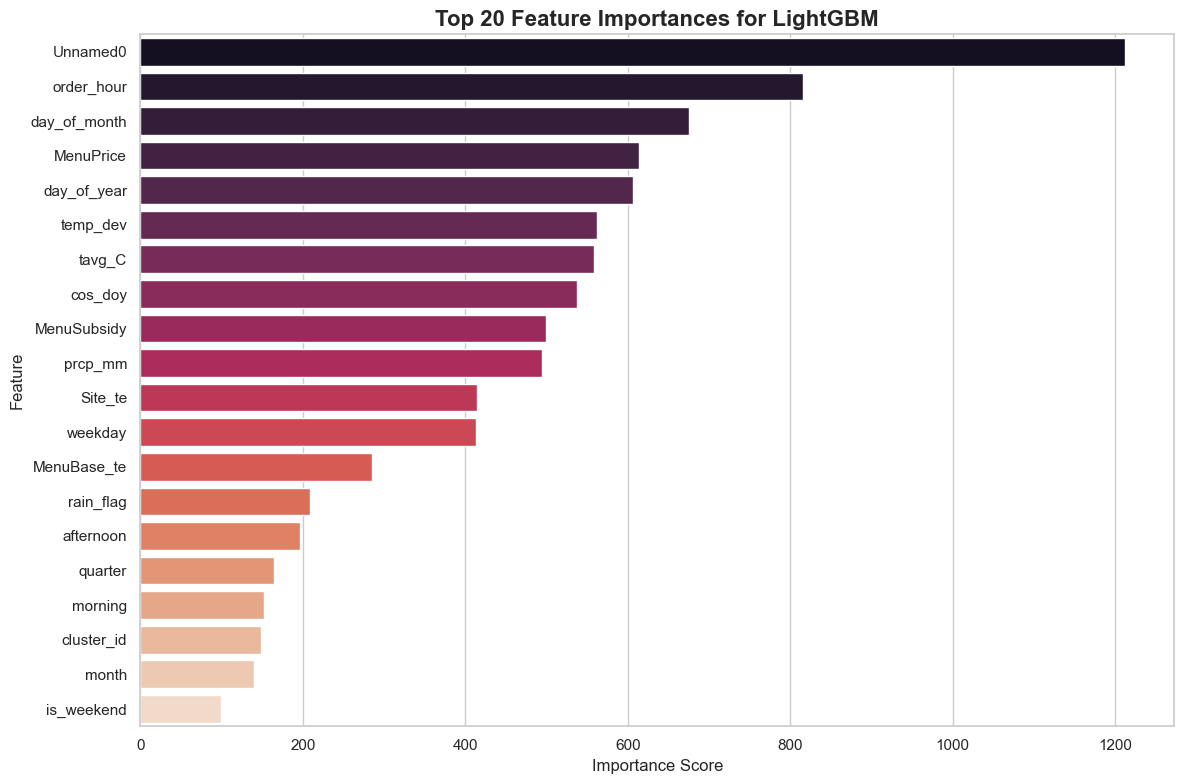


🎉 Analysis complete.


In [17]:
# =============================================================================
# 6. PERFORMANCE VISUALIZATION & ANALYSIS 📊
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_predict

# --- Setup for all plots ---
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.dpi'] = 100
print("\n==========================================================")
print("✅ GENERATING PERFORMANCE VISUALIZATIONS & ANALYSIS...")
print("==========================================================")

# =============================================================================
# Chart 1: Model Performance Comparison
# =============================================================================
# Store final scores in a dictionary for easy plotting
results = {
    'Stage A (Binary RF)': scores_A.mean(),
    'Stage B (Timing) - RF': search_rf.best_score_,
    'Stage B (Timing) - LGBM': search_lgbm.best_score_,
    'Stage B (Timing) - CatBoost': search_cat.best_score_
}

# Create a DataFrame from the results for plotting
df_results = pd.DataFrame(list(results.items()), columns=['Model', 'ROC_AUC Score']).sort_values('ROC_AUC Score',
                                                                                                 ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='ROC_AUC Score', y='Model', data=df_results, orient='h')
ax.set_title('Model Performance Comparison (ROC AUC)', fontsize=16, weight='bold')
ax.set_xlabel('ROC AUC Score (Higher is Better)', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.set_xlim(0.6, max(df_results['ROC_AUC Score']) * 1.1)  # Dynamic x-axis limit

# Add score labels to the bars
for i, v in enumerate(df_results['ROC_AUC Score']):
    ax.text(v + 0.005, i, f'{v:.4f}', color='black', va='center', weight='semibold')

plt.tight_layout()
plt.show()

# --- Identify the best Stage B model for deeper analysis ---
stage_b_results = {k: v for k, v in results.items() if 'Stage B' in k}
best_model_name = max(stage_b_results, key=stage_b_results.get)

if 'RF' in best_model_name:
    best_search_pipeline = search_rf.best_estimator_
    model_type_name = 'Random Forest'
elif 'LGBM' in best_model_name:
    best_search_pipeline = search_lgbm.best_estimator_
    model_type_name = 'LightGBM'
else:
    best_search_pipeline = search_cat.best_estimator_

print(f"\nPerforming detailed analysis on the best Stage B model: **{model_type_name}**")
# =============================================================================
# Chart 2: Error Analysis (Confusion Matrix) - CORRECTED
# =============================================================================
print("\nManually generating cross-validated predictions to respect time-series structure...")

# The error occurs because TimeSeriesSplit does not create a true "partition" of the
# data, as the earliest samples are never used in a test set.
# We will manually loop through the folds to correctly gather out-of-sample predictions.

all_predictions = []
all_true_labels = []

# Loop through each time-series split
for train_index, test_index in tscv_fast.split(X_B):
    # 1. Split data for this fold
    X_train, X_test = X_B.iloc[train_index], X_B.iloc[test_index]
    y_train = y_B[train_index]
    y_test_fold = y_B[test_index] # Capture the true labels for this fold

    # 2. Fit the best pipeline on the training data
    best_search_pipeline.fit(X_train, y_train)

    # 3. Predict on the test data and collect results
    fold_predictions = best_search_pipeline.predict(X_test)
    all_predictions.extend(fold_predictions)
    all_true_labels.extend(y_test_fold)

# Display a detailed classification report using the manually collected predictions
print("\nClassification Report (from Time-Series Cross-Validation):")
print("---------------------------------------------------------")
print(classification_report(all_true_labels, all_predictions, target_names=le.classes_, zero_division=0))

# Generate and plot the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical', colorbar=True)
ax.set_title(f'Confusion Matrix for {model_type_name} (Timing Prediction)', fontsize=16, weight='bold')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# =============================================================================
# Chart 3: Top Features (Feature Importance)
# =============================================================================
# Get the final, fitted classifier model from the pipeline
final_classifier = best_search_pipeline.named_steps['clf']

# To get the correct feature names, we need to process the data with all steps *before* the classifier
# Create a pipeline with all preprocessing steps
preprocessor_pipeline = ImbPipeline(best_search_pipeline.steps[:-2])  # All steps except smote and clf

# Fit and transform the data to get the final feature set
X_transformed = preprocessor_pipeline.fit_transform(X_B, y_B)
final_feature_names = X_transformed.columns

# Create a DataFrame of feature importances
feature_importances = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance': final_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the top 20 features
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20), orient='h', palette='rocket')
ax.set_title(f'Top 20 Feature Importances for {model_type_name}', fontsize=16, weight='bold')
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\n🎉 Analysis complete.")